# Optimizacion del k de kNN con weights distance_pow


## Buildear

In [ ]:
!cd .. && ./build.sh

## Carga de datos

In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd

df_train = pd.read_csv("../data/train.csv")
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB


### Reducir el dataset

Ya que el dataset es grande, me quedo con una porción de éste

**<font color=red>ESTO ES SOLO PARA HACER PRUEBAS. CUANDO REPORTEN LOS RESULTADOS, USAR DATASET COMPLETO</font>**

In [ ]:
df_train.sample(frac=1)
df_train = df_train[:1000]
df_train.info()

In [2]:
# Uso values para mandar todo a arrays de numpy
X = df_train[df_train.columns[1:]].values
y = df_train["label"].values.reshape(-1, 1)

X.shape, y.shape

((42000, 784), (42000, 1))

### Optimizacion de k con simmulated annealing

In [3]:
import metnum

import numpy.random as rn
import numpy as np

from scoring import cross_validation as cv
from scoring import metrics

k_range = (1, 100)
T = 100

# Seed del random para reproducibilidad del experimento
rn.seed(2020)

## Funciones parametro de simm ann

def clip_k(k):
    """Le pasas el state y lo pone en el rango valido"""
    a, b = k_range
    
    return max(a,min(b,int(k)))

def random_start():
    """Elige un state start aleatorio"""
    a, b = k_range
    rnd_k = a + (b - a) * rn.random_sample()
    return clip_k(rnd_k)

def random_neighbour(actual_k, fraction=0.0):
    """
    Varia un poco el estado actual para moverse en el espacio
    y probar una solucion distinta.
    """
    a, b = k_range
    new_k = actual_k
    
    MAX_ATTEMPTS = 10
    attempts = 0
    while new_k == actual_k and fraction != 1.0 and attempts < 10: # add circuit breaker at 10 attempts
        attempts += 1
        
        a, b = k_range
    
        # https://numpy.org/doc/1.18/reference/random/generated/numpy.random.random_sample.html
        # (b - a) * random_sample() + a
        # to sample Unif[a, b), with b > a
        
        n = (b - a)/2

        # Queremos de Unif[-n, n/2) para que tienda a negativos
        # (n/2 - -n) * random_sample() + -n
        # (3/2n) * random_sample() - n
        sample = (n/2 + n) * rn.random_sample() - n
        
        # Multiplicamos al sample por ese factor para que mientras mas cereca
        # del final de la optimizacion estemos, nos alejemos menos.
        delta = sample * (1.0-fraction)

        new_k = clip_k(actual_k + int(delta))
        
    return new_k

def acceptance_probability(cost, new_cost, temperature):
    """Probabilidad de aceptar una solucion como la nueva mejor"""
    if new_cost > cost: # cost en nuestro caso va a ser scoring
        # Si la solucion nueva es mejor que la anterior
        # la tomamos como la nueva mejor siempre.
        return 1

    p = np.exp(- ( cost - new_cost) / temperature)
    return p

def change_temperature(fraction):
    """Cuanto estas buscando soluciones"""
    return T*(1-fraction)


In [4]:
from metaheuristics import simulated_annealing as sa

K = 4

def scoring(k):
    # classifier a optimiazr
    clf = metnum.KNNClassifier(k, "distance_pow")
    accuracy = cv.cross_validate(clf, X, y, metrics.accuracy_score, K)
    return accuracy

best_state, history = sa.annealing(
    random_start,
    scoring,
    random_neighbour,
    acceptance_probability,
    change_temperature,
    max_state_reset_steps=10,
    max_steps=26,
    debug=True,
)

# Save history in df
df = pd.DataFrame(history, columns=["step", "state", "score", "best"])

starting simulated annealing


  0%|          | 0/25 [00:00<?, ?it/s]

initial: state = 98, score = 0.9414523809523809


  8%|▊         | 2/25 [33:31<6:25:39, 1006.08s/it]

#2 Found better solution [k = 73, score = 0.946595238095238]


 12%|█▏        | 3/25 [50:27<6:10:02, 1009.21s/it]

#3 Found better solution [k = 44, score = 0.9535]


 16%|█▌        | 4/25 [1:07:44<5:56:07, 1017.51s/it]

#4 Found better solution [k = 24, score = 0.9598571428571429]


 20%|██        | 5/25 [1:25:12<5:42:11, 1026.60s/it]

#5 Found better solution [k = 1, score = 0.9656190476190476]


 24%|██▍       | 6/25 [1:43:12<5:30:12, 1042.74s/it]

#6 Found better solution [k = 6, score = 0.9688809523809524]


 40%|████      | 10/25 [2:55:40<4:28:59, 1075.95s/it]

#10 Found better solution [k = 4, score = 0.9690238095238095]


 76%|███████▌  | 19/25 [5:22:11<1:36:32, 965.44s/it]

State reset


100%|██████████| 25/25 [7:06:48<00:00, 1024.35s/it]

Best solution: state = 4, score = 0.9690238095238095


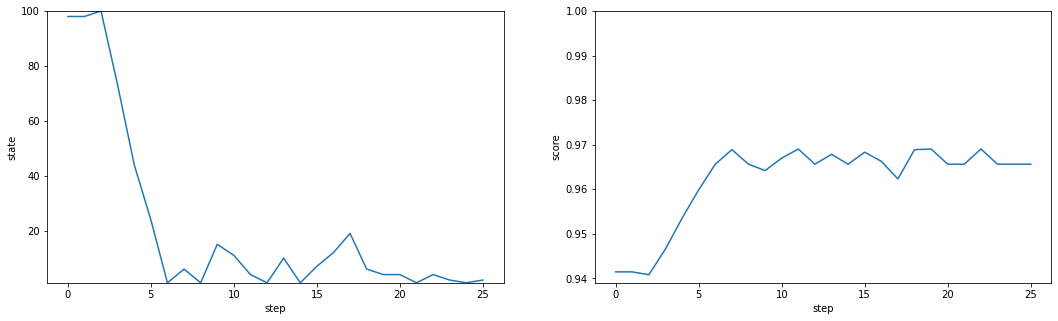

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, (ax_state, ax_score) = plt.subplots(1, 2, figsize=(18, 5))
ax_score.set_ylim(0.939, 1)
ax_state.set_ylim(k_range)
sns.lineplot(data=df, x="step", y="state", ax=ax_state)
sns.lineplot(data=df, x="step", y="score", ax=ax_score)

Text(0.5, 1.0, 'state by score for kNN')

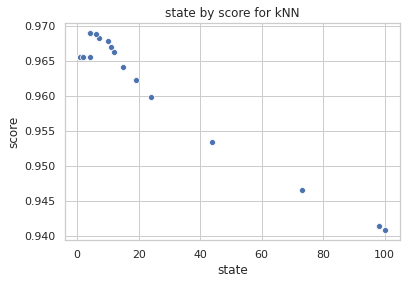

In [14]:
import seaborn as sns
sns.set(style="whitegrid")
plot = sns.scatterplot(
    data=df, x="state", y="score", 
    legend="full",
)
#plot.set_ylim(0.945, 0.98)
plot.set_title("state by score for kNN")

In [5]:
df.to_csv("data/knn/optimization/history_best_4.csv", index=False)

In [ ]:
## concluimos que distance_pow es el mejor
## TODO: graficar cosas